In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [ ]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
file_path = 'data_input_auto/中国主营销售库存.xlsx'
excel_data = pd.ExcelFile(file_path)
sheet = excel_data.parse('Sheet1')
sheet.rename(columns={'DataTime': 'Date'}, inplace=True)
sheet['Date'] = pd.to_datetime(sheet['Date'], errors='coerce')

sheet.set_index('Date', inplace=True)
full_date_range = pd.date_range(start=sheet.index.min(), end=sheet.index.max(), freq='D')
sheet_daily = sheet.reindex(full_date_range)

In [4]:
sheet_daily.columns

Index(['中国主营成品油销售公司汽油库存', 'WESTPAC中国经济惊喜指数/4WMA', 'A股餐饮旅游指数60日环比/30DMA',
       '新增社融/3MMA同比', '新能源汽车渗透率（内销口径）'],
      dtype='object')

In [5]:
fill_methods = {
    '中国主营成品油销售公司汽油库存': 'interpolate', 
    'WESTPAC中国经济惊喜指数/4WMA': 'interpolate',
    'A股餐饮旅游指数60日环比/30DMA': 'interpolate',
    '新增社融/3MMA同比': 'interpolate',
    '新能源汽车渗透率（内销口径）': 'interpolate'
} 
sheet_daily = fill_missing_values(sheet_daily, fill_methods, return_only_filled=False)

# 获取当前的最后一个日期
last_date = sheet_daily.index.max()
extended_date_range = pd.date_range(start=sheet_daily.index.min(), end=last_date + pd.Timedelta(days=30), freq='D')
sheet_daily_extended = sheet_daily.reindex(extended_date_range)

sheet_daily_extended['WESTPAC中国经济惊喜指数/4WMA_提前92天'] = sheet_daily_extended['WESTPAC中国经济惊喜指数/4WMA'].shift(92)
sheet_daily_extended['A股餐饮旅游指数60日环比/30DMA_提前105天'] = sheet_daily_extended['A股餐饮旅游指数60日环比/30DMA'].shift(105)
sheet_daily_extended['新增社融/3MMA同比_提前210天'] = sheet_daily_extended['新增社融/3MMA同比'].shift(210)
sheet_daily_extended['新能源汽车渗透率（内销口径）_提前90天'] = sheet_daily_extended['新能源汽车渗透率（内销口径）'].shift(90)
sheet_daily_extended['新能源汽车渗透率（内销口径）_提前90天_逆序'] = reverse_column(sheet_daily_extended, '新能源汽车渗透率（内销口径）_提前90天')

sheet_daily_extended.reset_index(inplace=True)
sheet_daily_extended.rename(columns={'index': 'Date'}, inplace=True)

sheet_daily_extended = sheet_daily_extended[sheet_daily_extended['Date'] >= '2022-01-01']
last_day = sheet['中国主营成品油销售公司汽油库存'].last_valid_index()

In [6]:
sheet_daily_extended

,Date,中国主营成品油销售公司汽油库存,WESTPAC中国经济惊喜指数/4WMA,A股餐饮旅游指数60日环比/30DMA,新增社融/3MMA同比,新能源汽车渗透率（内销口径）,WESTPAC中国经济惊喜指数/4WMA_提前92天,A股餐饮旅游指数60日环比/30DMA_提前105天,新增社融/3MMA同比_提前210天,新能源汽车渗透率（内销口径）_提前90天,新能源汽车渗透率（内销口径）_提前90天_逆序
7988,2022-01-01,742.571429,39.549643,-0.0703,0.2520,0.198713,19.892500,-0.1892,-0.349783,0.175097,0.346803
7989,2022-01-02,741.142857,39.774286,-0.0711,0.2513,0.197526,20.431786,-0.1894,-0.345000,0.174329,0.347571
7990,2022-01-03,739.714286,39.998929,-0.0719,0.2506,0.196339,20.971071,-0.1896,-0.340217,0.173561,0.348339
7991,2022-01-04,738.285714,40.223571,-0.0727,0.2499,0.195152,21.510357,-0.1898,-0.335433,0.172794,0.349106
7992,2022-01-05,736.857143,40.448214,-0.0764,0.2492,0.193965,22.049643,-0.1900,-0.330650,0.172026,0.349874
...,...,...,...,...,...,...,...,...,...,...,...
9229,2025-05-26,NaN,NaN,NaN,NaN,NaN,53.782500,-0.0064,-0.091832,0.445754,0.076146
9230,2025-05-27,NaN,NaN,NaN,NaN,NaN,53.782500,-0.0213,-0.094055,0.447336,0.074564
9231,2025-05-28,NaN,NaN,NaN,NaN,NaN,53.782500,-0.0344,-0.096277,0.448918,0.072982
9232,2025-05-29,NaN,NaN,NaN,NaN,NaN,53.782500,-0.0458,-0.098500,0.450500,0.071400


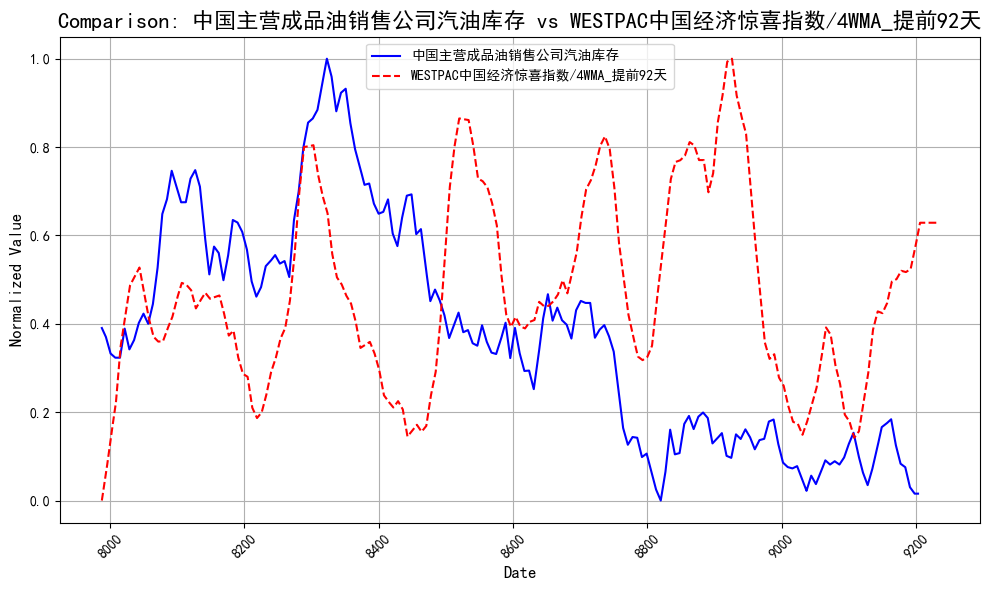

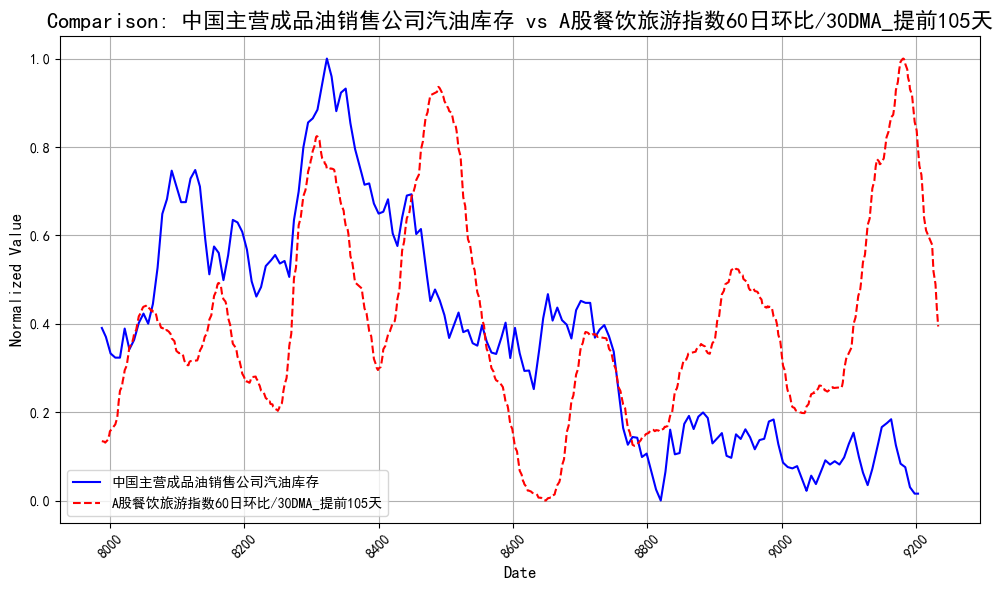

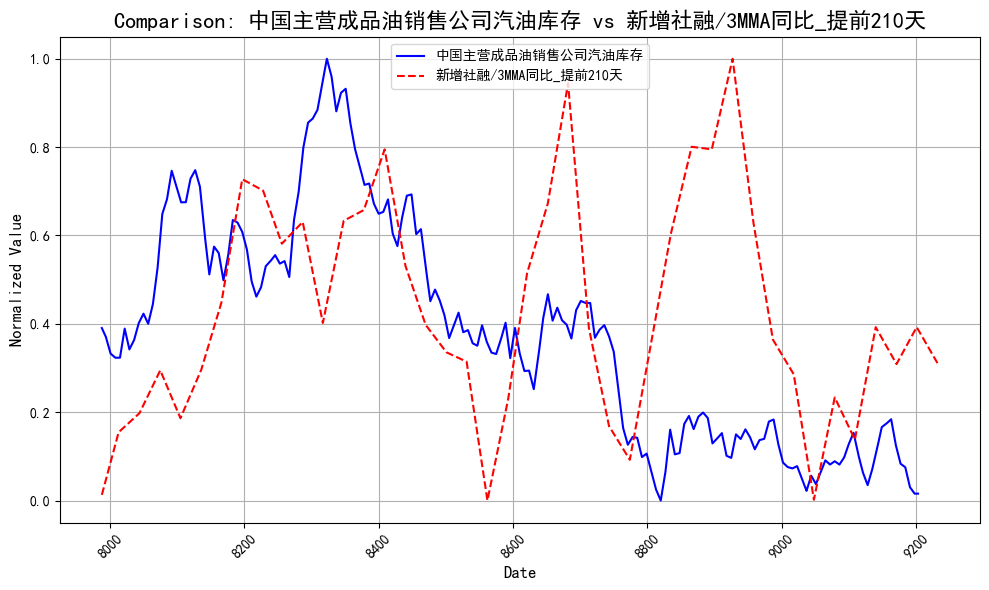

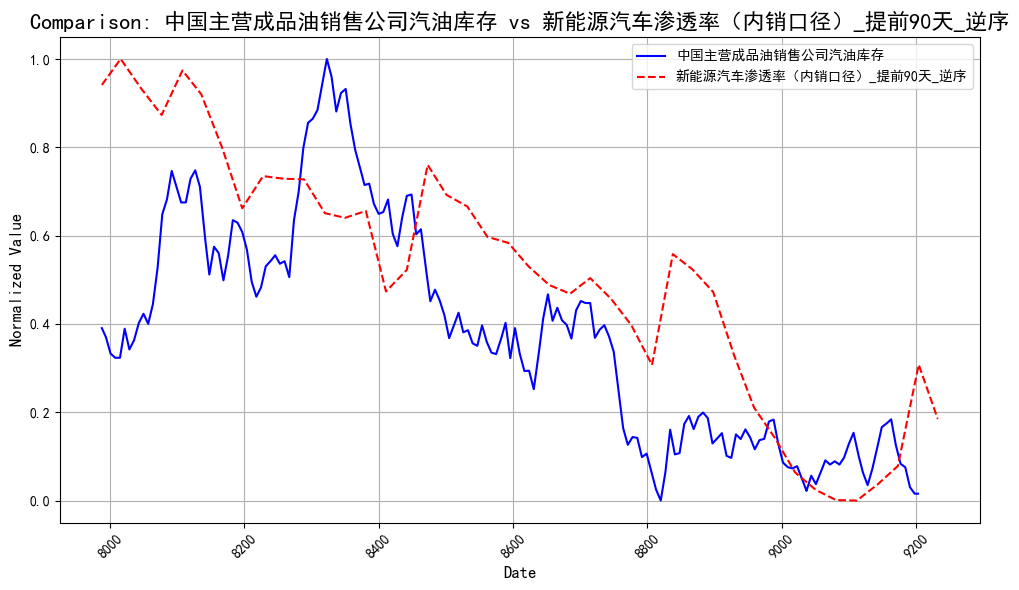

In [7]:
plot_comparison_multiple(
    sheet_daily_extended, 
    main_col='中国主营成品油销售公司汽油库存', 
    compare_cols=['WESTPAC中国经济惊喜指数/4WMA_提前92天', 'A股餐饮旅游指数60日环比/30DMA_提前105天',
       '新增社融/3MMA同比_提前210天', '新能源汽车渗透率（内销口径）_提前90天_逆序']
)

In [8]:
# 划分训练集、测试集和未来数据
train_data = sheet_daily_extended[sheet_daily_extended['Date'] <= last_day].copy()
test_period = 80
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily_extended[sheet_daily_extended['Date'] > last_day].copy()

# 因子集
feature_columns = [
'WESTPAC中国经济惊喜指数/4WMA_提前92天', 'A股餐饮旅游指数60日环比/30DMA_提前105天',
       '新增社融/3MMA同比_提前210天', '新能源汽车渗透率（内销口径）_提前90天_逆序'
]
# 预测目标column
predict_column = '中国主营成品油销售公司汽油库存'

# 准备训练、测试和未来数据的输入和输出
X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

In [9]:
# 初始化 MinMaxScaler
scaler = StandardScaler()

# 归一化特征数据
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

# 定义并训练 XGBRegressor 模型
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=150, learning_rate=0.05, max_depth=4, subsample=0.9, colsample_bytree=0.8)
xgb.fit(X_train_scaled, y_train)


# 训练集和测试集的预测
y_train_pred = xgb.predict(X_train_scaled)
y_test_pred = xgb.predict(X_test_scaled)

# 计算 MSE 和 R^2 分数
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse}, Train R^2: {train_r2}")
print(f"Test MSE: {test_mse}, Test R^2: {test_r2}")


# 未来预测
X_all = sheet_daily_extended[sheet_daily_extended['Date'] <= last_day][feature_columns]
y_all = sheet_daily_extended[sheet_daily_extended['Date'] <= last_day][predict_column]

# 归一化所有历史特征数据
X_all_scaled = scaler.fit_transform(X_all)

xgb_all = XGBRegressor(objective='reg:squarederror', n_estimators=150, learning_rate=0.05, max_depth=4, subsample=0.9, colsample_bytree=0.8)
# 使用所有历史数据重新训练模型
xgb_all.fit(X_all_scaled, y_all)

y_future_pred = xgb_all.predict(X_future_scaled)

test_data = test_data.copy()
future_data = future_data.copy()

test_data.loc[:, '预测值'] = y_test_pred
future_data.loc[:, '预测值'] = y_future_pred

Train MSE: 81.10419367117693, Train R^2: 0.9926321444163198
Test MSE: 672.5560585222853, Test R^2: -0.24552015910876257


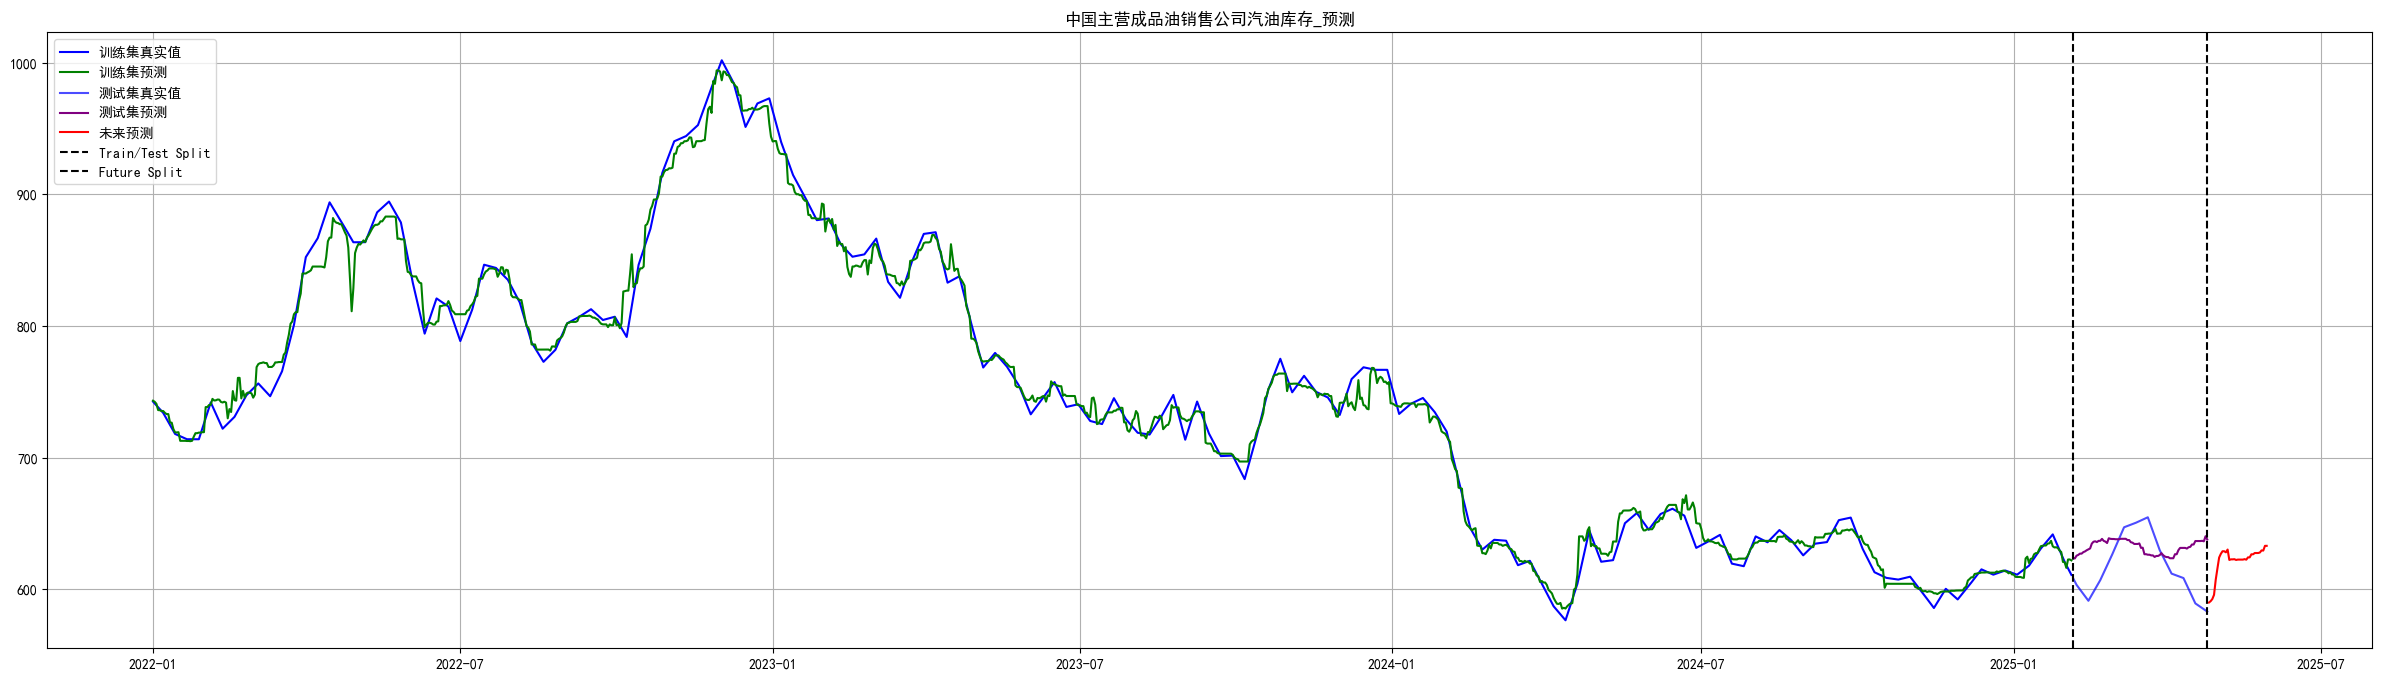

In [10]:
# 可视化
plt.figure(figsize=(30, 8))

plt.plot(train_data['Date'], y_train, label='训练集真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集真实值', color='blue',alpha=0.7)
plt.plot(test_data['Date'], test_data['预测值'], label='测试集预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')

plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('中国主营成品油销售公司汽油库存_预测')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# 添加未来预测值
future_predictions = future_data[['Date', '预测值']].copy()
future_predictions.columns = ['Date', '中国主营成品油销售公司汽油库存']

future_predictions.to_excel('data_output_auto/中国主营成品油销售公司汽油库存预测结果.xlsx', index=False)

---

In [12]:
# 任务1: 合并训练集、测试集真实值和未来预测
# 获取2023年以后的训练集数据
train_data_2023 = train_data[train_data['Date'].dt.year >= 2023][['Date', '中国主营成品油销售公司汽油库存']]
test_actual = test_data[['Date', '中国主营成品油销售公司汽油库存']]

# 合并训练集和测试集的真实值
historical_actual = pd.concat([train_data_2023, test_actual])
historical_actual.columns = ['Date', '实际值']

# 获取未来预测值
future_pred = future_data[['Date', '预测值']]  # 修改这里的列名
future_pred.columns = ['Date', '预测值']

# 合并所有数据
merged_df = pd.merge(historical_actual, future_pred, on='Date', how='outer')
merged_df = merged_df.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
merged_df['Date'] = merged_df['Date'].dt.strftime('%Y/%m/%d')

# 保存到Excel
merged_df.to_excel('eta/中国主营销售库存_合并数据.xlsx', index=False, float_format='%.2f')
merged_df

,Date,实际值,预测值
880,2025/05/30,NaN,633.000183
879,2025/05/29,NaN,633.000183
878,2025/05/28,NaN,629.398804
877,2025/05/27,NaN,629.531738
876,2025/05/26,NaN,627.928406
...,...,...,...
4,2023/01/05,944.482857,NaN
3,2023/01/04,949.240714,NaN
2,2023/01/03,953.998571,NaN
1,2023/01/02,958.756429,NaN


In [13]:
# 任务2: 生成月度数据
# 获取2023年以后的实际值
actual_values = pd.concat([
    train_data[train_data['Date'].dt.year >= 2023][['Date', '中国主营成品油销售公司汽油库存']],
    test_data[['Date', '中国主营成品油销售公司汽油库存']]
])
actual_values.columns = ['Date', '实际值']

# 创建包含2024年及以后训练集预测值的DataFrame
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred[train_data['Date'].dt.year >= 2024]
})

# 重新构建predictions DataFrame
predictions = pd.concat([
    train_pred_2024,
    test_data[['Date', '预测值']],
    future_data[['Date', '预测值']]
], ignore_index=True)

# 重新合并实际值和预测值
monthly_df = pd.merge(actual_values, predictions, on='Date', how='outer')

# 转换为月度数据
monthly_df['Date'] = pd.to_datetime(monthly_df['Date'])
monthly_df.set_index('Date', inplace=True)
monthly_df = monthly_df.resample('ME').mean()
monthly_df.reset_index(inplace=True)
monthly_df = monthly_df.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
monthly_df['Date'] = monthly_df['Date'].dt.strftime('%Y/%m/%d')
# 保存月度数据
monthly_df.to_excel('eta/中国主营销售库存_月度数据.xlsx', index=False, float_format='%.2f')
monthly_df.head()

,Date,实际值,预测值
29,2025/06/30,NaN,628.089539
28,2025/05/31,NaN,625.612915
27,2025/04/30,598.625905,619.761169
26,2025/03/31,643.178737,616.416016
25,2025/02/28,606.407636,615.723267


---

In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "汽油中国主营销售库存"

# 调用函数更新数据
success = update_excel_data(merged_df, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "汽油中国主营销售库存"
# 调用函数更新数据
success = update_excel_data(monthly_df, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/04/30)
数据已成功更新到Excel文件
